In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**1.Load,visualizing and displaying DICOM**

Total DICOM files found: 18000
Example file: /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/83caa8a85e03606cf57e49147d7ac569.dicom


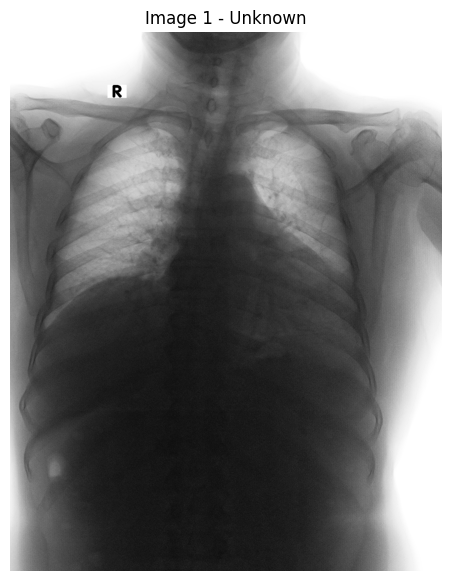

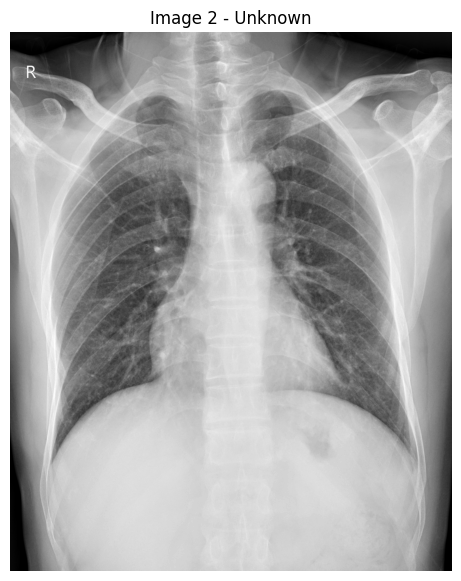

In [1]:
import os
import pydicom
import matplotlib.pyplot as plt

# Automatically search for DICOM files in the dataset
dicom_files = []
for root, _, files in os.walk('/kaggle/input'):
    for f in files:
        if f.lower().endswith(('.dcm', '.dicom')):
            dicom_files.append(os.path.join(root, f))

# Check dataset
print("Total DICOM files found:", len(dicom_files))
print("Example file:", dicom_files[0])

# Display first 2 images with metadata
for i in range(2):
    dcm = pydicom.dcmread(dicom_files[i])
    img = dcm.pixel_array
    
    # Normalize for clarity
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(7,7))
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {i+1} - {dcm.get('ViewPosition', 'Unknown')}")
    plt.axis('off')
    plt.show()


**2.Bounding box(problem finding area)**


Showing: 9a5094b2563a1ef3ff50dc5c7ff71345


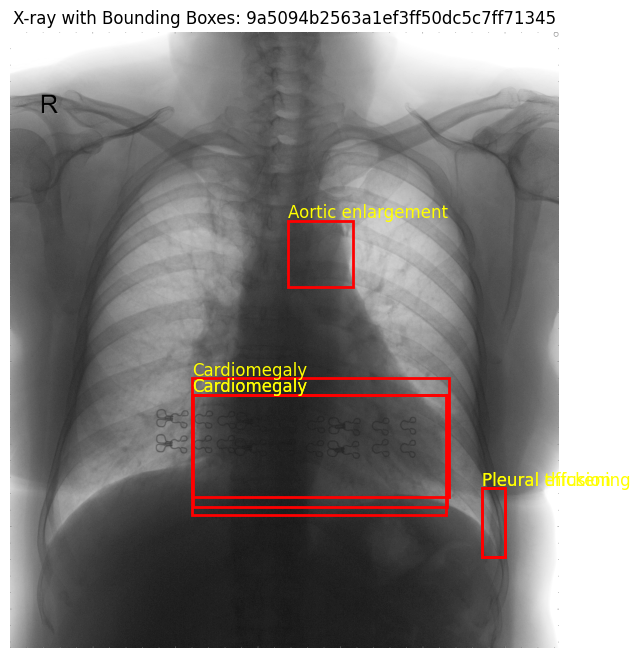


Showing: 051132a778e61a86eb147c7c6f564dfe


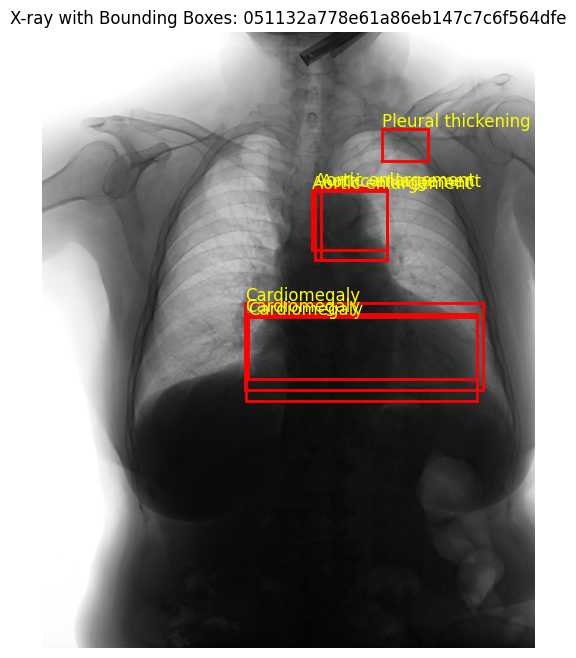


Showing: 1c32170b4af4ce1a3030eb8167753b06


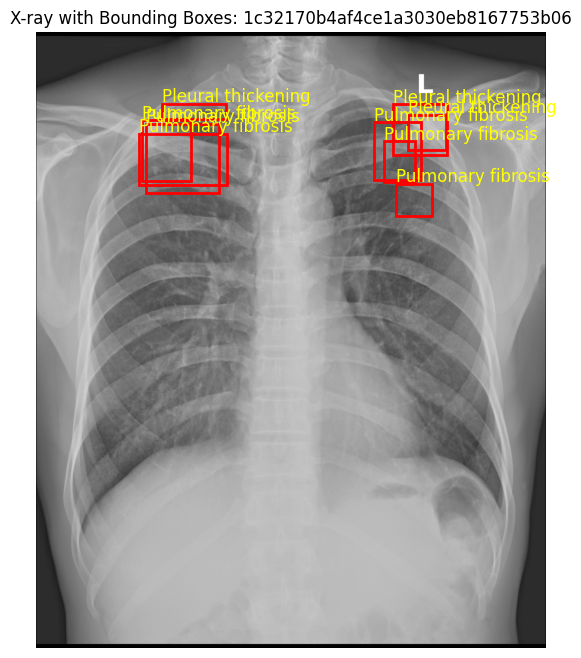


Showing: 0c7a38f293d5f5e4846aa4ca6db4daf1


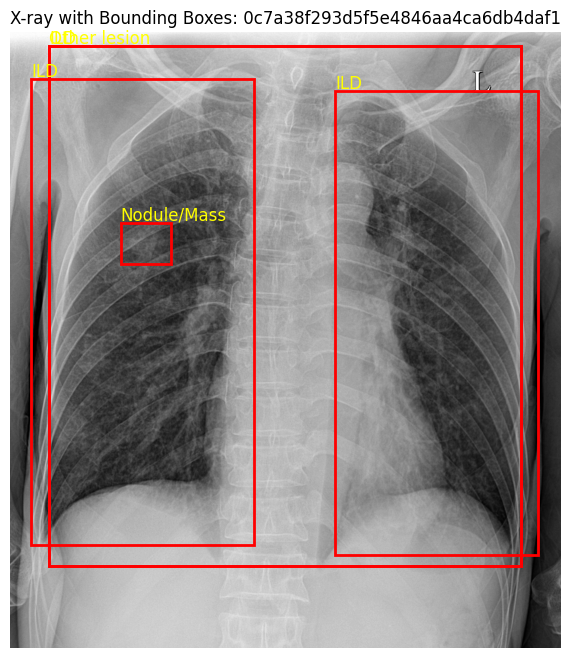


Showing: 47ed17dcb2cbeec15182ed335a8b5a9e


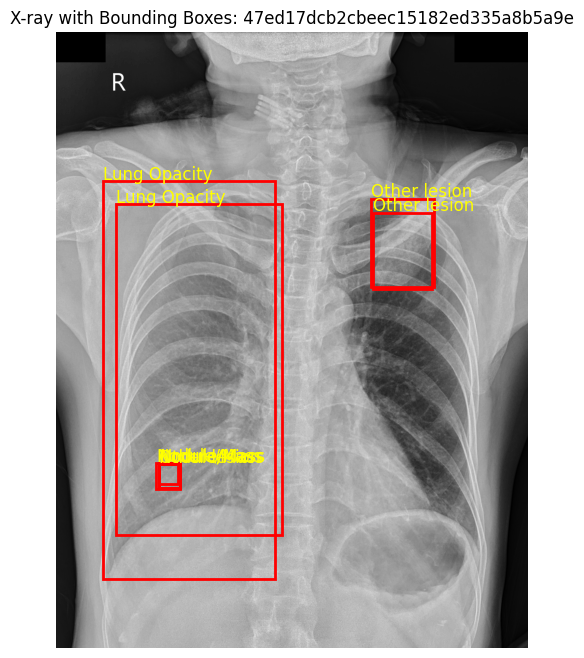

In [2]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load CSV
csv_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"
df = pd.read_csv(csv_path)

# Filter rows that have abnormalities (skip “No finding”)
bb_df = df[df['class_name'] != "No finding"].copy()

# Get 5 unique image IDs that contain bounding boxes
image_ids = bb_df['image_id'].unique()[:5]

for img_id in image_ids:
    print(f"\nShowing: {img_id}")

    # Load DICOM
    dicom_path = f"/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/{img_id}.dicom"
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array

    # Start Plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img, cmap='gray')

    # Get ALL bounding boxes for this image
    rows = bb_df[bb_df['image_id'] == img_id]

    # Draw bounding boxes
    for idx, r in rows.iterrows():
        x = r['x_min']
        y = r['y_min']
        w = r['x_max'] - r['x_min']
        h = r['y_max'] - r['y_min']

        rect = patches.Rectangle((x, y), w, h,
                                 linewidth=2,
                                 edgecolor='red',
                                 facecolor='none')
        ax.add_patch(rect)

        # Label
        ax.text(x, y-10, r['class_name'], color='yellow', fontsize=12)

    plt.title(f"X-ray with Bounding Boxes: {img_id}")
    plt.axis('off')
    plt.show()


**3.preprocessing**

In [ ]:








import os
import pydicom
import torch
import cv2
import numpy as np
from tqdm import tqdm

# 1) Find all DICOM files automatically
dicom_files = []
for root, _, files in os.walk('/kaggle/input'):
    for f in files:
        if f.lower().endswith(('.dcm', '.dicom')):
            dicom_files.append(os.path.join(root, f))

print("Total DICOMs found:", len(dicom_files))

# 2) Folder to save tensors
save_folder = "/kaggle/working/preprocessed_tensors"
os.makedirs(save_folder, exist_ok=True)

print("Saving tensors to:", save_folder)


# 3) Preprocessing function (normalize + resize + tensor)
def preprocess_dicom(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32)

    # Normalize 0–255
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    # Resize (224×224)
    img = cv2.resize(img, (224, 224))

    # Convert to tensor (1 × 224 × 224)
    tensor = torch.tensor(img).unsqueeze(0)
    return tensor


# 4) MAIN LOOP with AUTO-RESUME
for i, dicom_path in enumerate(tqdm(dicom_files)):

    tensor_name = f"tensor_{i}.pt"
    save_path = os.path.join(save_folder, tensor_name)

    # --- AUTO RESUME ---
    if os.path.exists(save_path):
        continue

    try:
        tensor = preprocess_dicom(dicom_path)
        torch.save(tensor, save_path)
    except Exception as e:
        print("Error:", dicom_path, e)

print("✔️ Preprocessing Completed Successfully!")


Total DICOMs found: 18000
Saving tensors to: /kaggle/working/preprocessed_tensors


 24%|██▍       | 4410/18000 [1:02:34<5:47:19,  1.53s/it]